In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [3]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

8.6%

100.0%


Extracting /tmp/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw



100.0%
49.7%

Extracting /tmp/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw



100.0%
100.0%


Extracting /tmp/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw

Extracting /tmp/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw



In [4]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.70

In [5]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [6]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [7]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [8]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 10])


In [9]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 57.971


In [10]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 8.59%


In [11]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [12]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 54.875
Train set accuracy for a single minibatch: 8.59%


In [23]:
# Train

num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 700.85
Test Set Loss: 203.38
Train set accuracy for a single minibatch: 91.41%
Test set accuracy for a single minibatch: 82.03%


Epoch 0, Iteration 50
Train Set Loss: 19.11
Test Set Loss: 5.43
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 100
Train Set Loss: 6.85
Test Set Loss: 6.94
Train set accuracy for a single minibatch: 94.53%
Test set accuracy for a single minibatch: 96.09%


Epoch 0, Iteration 150
Train Set Loss: 6.06
Test Set Loss: 11.10
Train set accuracy for a single minibatch: 94.53%
Test set accuracy for a single minibatch: 92.97%


Epoch 0, Iteration 200
Train Set Loss: 3.66
Test Set Loss: 12.33
Train set accuracy for a single minibatch: 96.88%
Test set accuracy for a single minibatch: 91.41%


Epoch 0, Iteration 250
Train Set Loss: 4.55
Test Set Loss: 2.09
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 96.88%


Epoch 

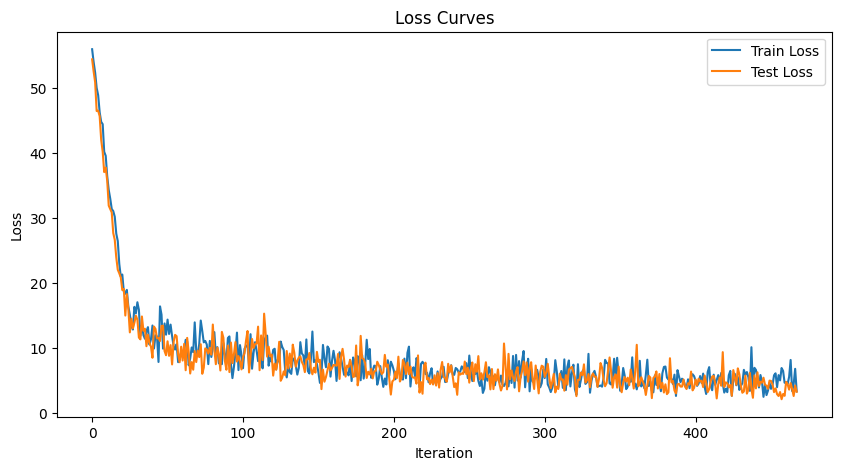

In [14]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [43]:
# Test Accuracy

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 6366/10000
Test Set Accuracy: 63.66%


In [16]:
torch.save(net.state_dict(), 'MNIST_SNN.pth')

In [25]:
print(f"Net Parameters:")
print(net)

print(f"Net First Layer Parameters:")
print(net.fc1)

Net Parameters:
Net(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
  (lif2): Leaky()
)
Net First Layer Parameters:
Linear(in_features=784, out_features=1000, bias=True)


In [44]:
# Print the initial weights
print("Initial weights:", net.fc1.weight)

# Access the parameters
parameters = net.parameters()

# Assuming you want to modify the weights of the first neuron in the linear layer
neuron_index = 1    # 0 to 999
for param in parameters:
    if param is net.fc1.weight:
        # Modify the weights of the first neuron
        new_weights = torch.randn(param.size(1))  # Example: Initialize new weights randomly
        param.data[neuron_index] = new_weights

# Print the modified weights
print("Modified weights:", net.fc1.weight)
print("Size of Weights: ", net.fc1.weight.size())

Initial weights: Parameter containing:
tensor([[ 2.0512,  0.5744, -1.9530,  ...,  0.5096,  1.5722, -0.3315],
        [-0.0129, -0.0069,  0.0354,  ..., -0.0322,  0.0141,  0.0338],
        [ 0.0325,  0.0050, -0.0124,  ..., -0.0054, -0.0287,  0.0202],
        ...,
        [ 0.0247,  0.0329, -0.0284,  ...,  0.0091, -0.0173,  0.0355],
        [ 0.0318, -0.0346, -0.0317,  ...,  0.0135, -0.0146,  0.0097],
        [ 0.1861,  0.4190, -0.6578,  ...,  1.0619,  0.2682, -0.6024]],
       device='cuda:0', requires_grad=True)
Modified weights: Parameter containing:
tensor([[ 2.0512,  0.5744, -1.9530,  ...,  0.5096,  1.5722, -0.3315],
        [-0.3175, -0.0470,  0.3751,  ..., -1.7433, -0.9690, -0.3680],
        [ 0.0325,  0.0050, -0.0124,  ..., -0.0054, -0.0287,  0.0202],
        ...,
        [ 0.0247,  0.0329, -0.0284,  ...,  0.0091, -0.0173,  0.0355],
        [ 0.0318, -0.0346, -0.0317,  ...,  0.0135, -0.0146,  0.0097],
        [ 0.1861,  0.4190, -0.6578,  ...,  1.0619,  0.2682, -0.6024]],
       de

In [35]:
# Print the initial weights
print("Initial weights:", net.fc2.weight)

# Access the parameters
parameters = net.parameters()

# Assuming you want to modify the weights of the first neuron in the linear layer
neuron_index = 4     # 0 to 9
for param in parameters:
    if param is net.fc2.weight:
        # Modify the weights of the first neuron
        new_weights = torch.randn(param.size(1))  # Example: Initialize new weights randomly
        param.data[neuron_index] = new_weights

# Print the modified weights
print("Modified weights:", net.fc2.weight)
print("Size of Weights: ", net.fc2.weight.size())

Initial weights: Parameter containing:
tensor([[-0.0255,  0.0398, -0.0234,  ..., -0.0399,  0.0409, -0.0981],
        [-0.0098,  0.0288, -0.0694,  ...,  0.0386, -0.0479, -0.0439],
        [-0.0618,  0.0317, -0.0572,  ..., -0.0483,  0.0360, -0.0632],
        ...,
        [-0.0498, -0.0387, -0.0365,  ...,  0.0042, -0.0258, -0.0543],
        [-0.0387,  0.0197, -0.0852,  ..., -0.0397,  0.0130, -0.1450],
        [ 0.0578, -0.0031,  0.0285,  ..., -0.0380, -0.0362,  0.0638]],
       device='cuda:0', requires_grad=True)
Modified weights: Parameter containing:
tensor([[-0.0255,  0.0398, -0.0234,  ..., -0.0399,  0.0409, -0.0981],
        [-0.0098,  0.0288, -0.0694,  ...,  0.0386, -0.0479, -0.0439],
        [-0.0618,  0.0317, -0.0572,  ..., -0.0483,  0.0360, -0.0632],
        ...,
        [-0.0498, -0.0387, -0.0365,  ...,  0.0042, -0.0258, -0.0543],
        [-0.0387,  0.0197, -0.0852,  ..., -0.0397,  0.0130, -0.1450],
        [ 0.0578, -0.0031,  0.0285,  ..., -0.0380, -0.0362,  0.0638]],
       de

In [20]:
import torch
import torch.nn as nn

# Define a simple neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(10, 1)  # Linear layer with input size 10 and output size 1

    def forward(self, x):
        x = self.fc(x)
        return x

# Create an instance of the network
model = SimpleNet()

# Print the initial weights
print("Initial weights:", model.fc.weight)

# Access the parameters
parameters = model.parameters()

# Assuming you want to modify the weights of the first neuron in the linear layer
neuron_index = 0
for param in parameters:
    if param is model.fc.weight:
        # Modify the weights of the first neuron
        new_weights = torch.randn(param.size())  # Example: Initialize new weights randomly
        param.data[neuron_index] = new_weights

# Print the modified weights
print("Modified weights:", model.fc.weight)

Initial weights: Parameter containing:
tensor([[ 0.1161,  0.2124, -0.1982,  0.1422, -0.2248, -0.0107,  0.1986, -0.2937,
          0.0033,  0.1775]], requires_grad=True)
Modified weights: Parameter containing:
tensor([[ 1.2624,  0.4253,  1.2957,  0.3380,  0.3385, -0.1398,  0.0859,  1.2952,
          0.2880, -1.0417]], requires_grad=True)
